# Прогнозирование уровня средней заработной платы в России

In [ ]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [42]:
salary = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.describe()

,WAG_C_M
count,284.000000
mean,12197.920775
std,12001.029418
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


### Визуальный Анализ

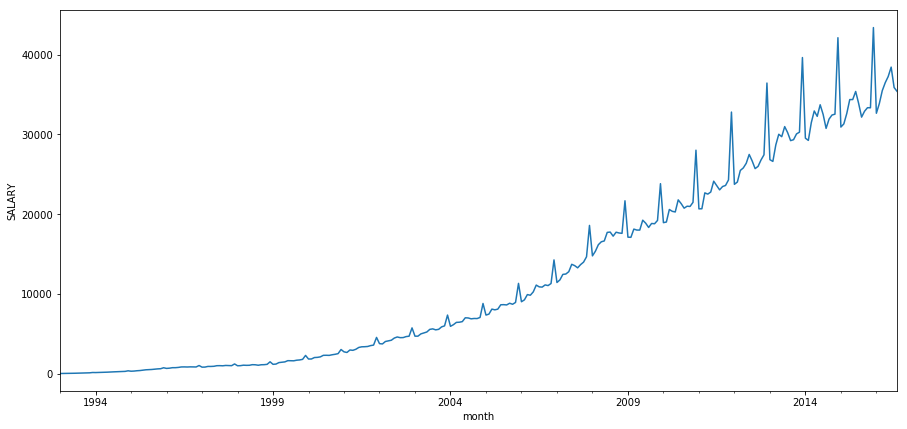

In [20]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('SALARY')
pylab.show()

#### В ряду есть сезонность и тренд. Требуется стабилизация дисперсии.

Критерий Дики-Фуллера: p=0.996491


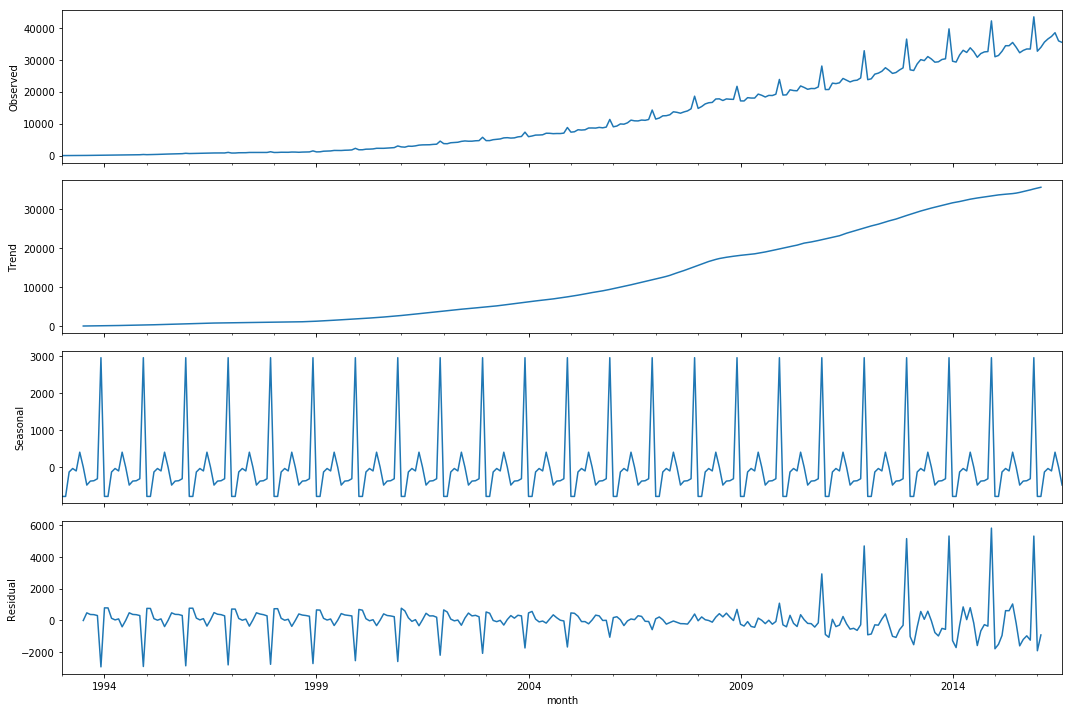

In [21]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

#### Ряд не стационарен. Преобразуем его. Избавимся от тренда, сезонности, добьемся стационарности.

#### Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263044
Критерий Дики-Фуллера: p=0.757007


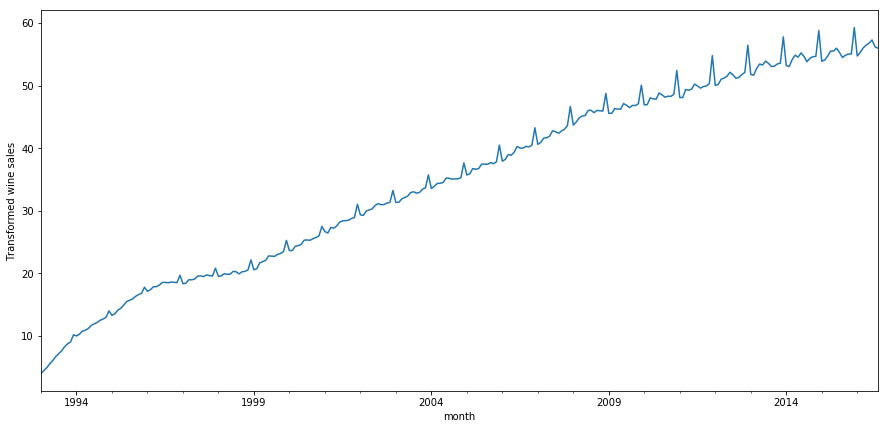

In [46]:
salary['box_cox'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.box_cox.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_cox)[1])

#### Сезонное дифференциирование:

Критерий Дики-Фуллера: p=0.007911


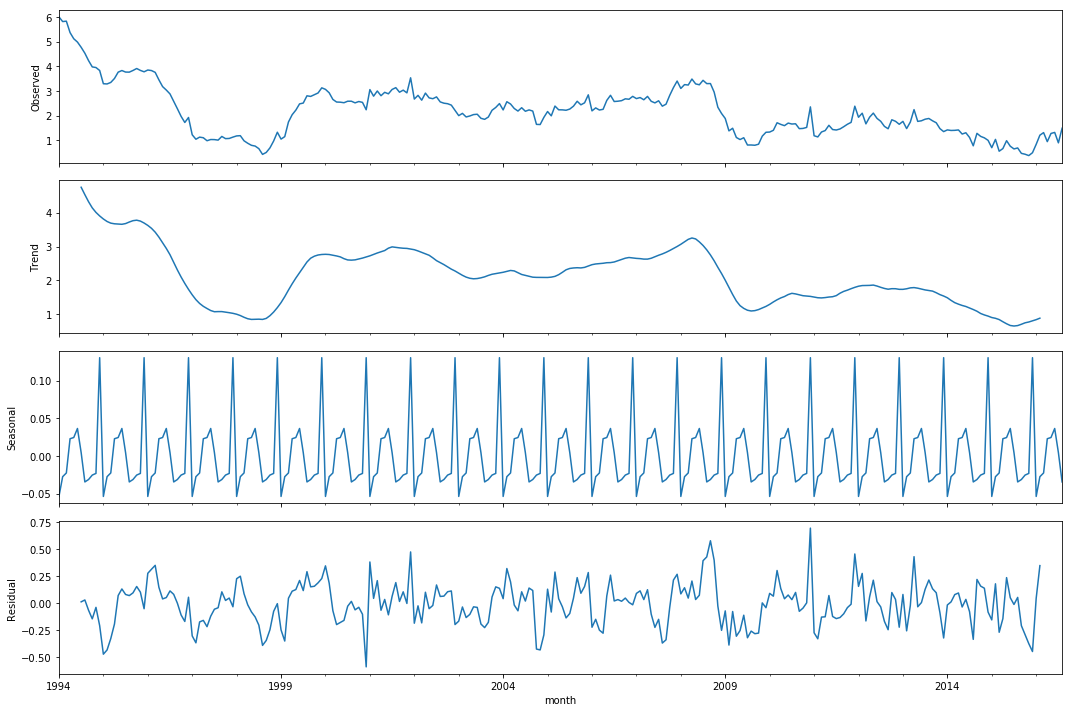

In [47]:
salary['box_diff'] = salary.box_cox - salary.box_cox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff[12:])[1])

#### Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


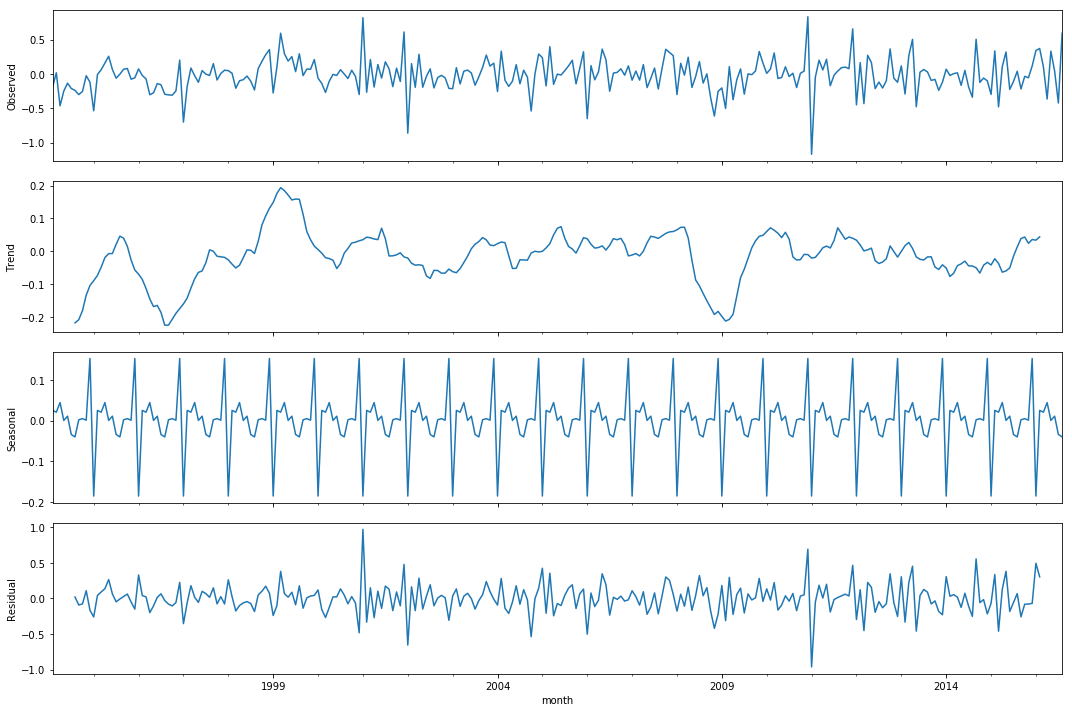

In [48]:
salary['box_diff2'] = salary.box_diff - salary.box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff2[13:])[1])

#### Вот теперь хорошо. Построим автокоррелограммы.

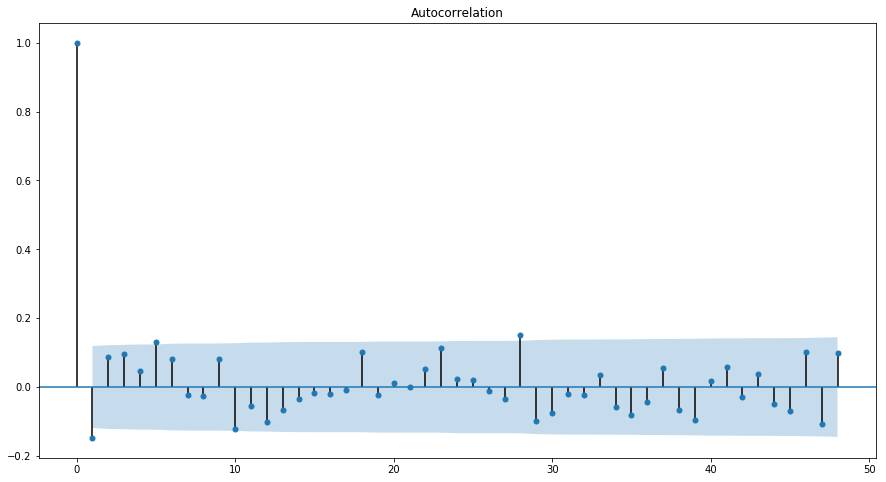

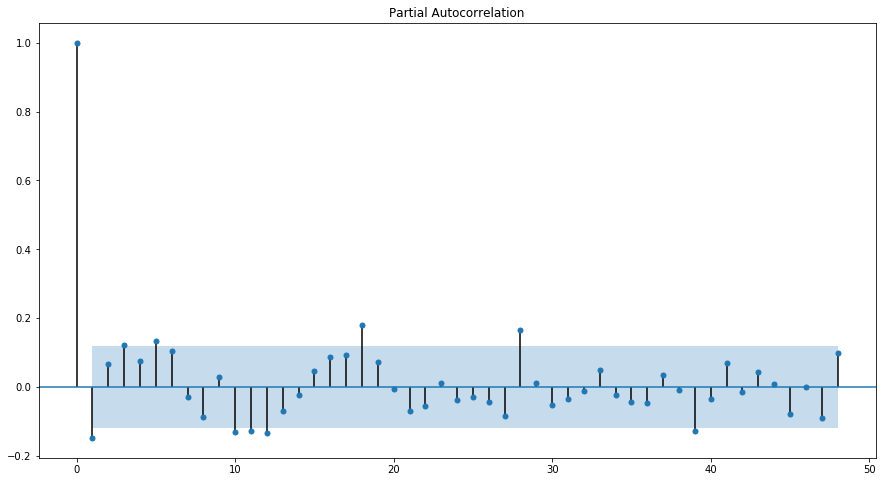

In [29]:
plt.figure()
ax = plt.subplot()
sm.graphics.tsa.plot_acf(salary.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot()
sm.graphics.tsa.plot_pacf(salary.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

#### Подберем Q, q, P, p

In [33]:
ps = range(0, 11)
d=1
qs = range(0, 1)
Ps = range(0, 1)
D=1
Qs = range(0, 4)

In [34]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

44

#### Обучим все модели SARIMAX. Выберем лучшую.

In [35]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.box_cox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
CPU times: user 1min 3s, sys: 2.13 s, total: 1min 5s
Wall time: 36.4 s


In [49]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            box_cox   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 12)   Log Likelihood                  10.228
Date:                            Tue, 22 Aug 2017   AIC                             -4.455
Time:                                    17:57:22   BIC                             24.737
Sample:                                01-01-1993   HQIC                             7.248
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2120      0.045     -4.740      0.000      -0.300      -0.124
ar.L2          0.0247      0.066   

#### Остатки модели

Критерий Стьюдента: p=0.367310
Критерий Дики-Фуллера: p=0.000000


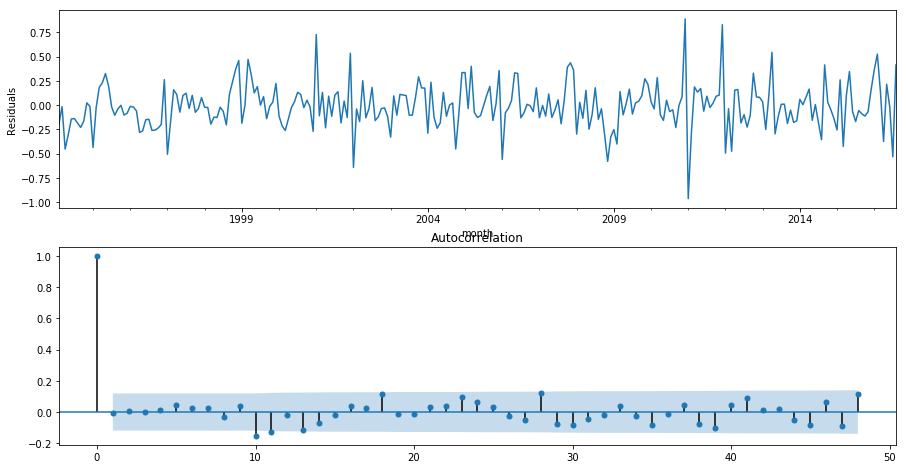

In [50]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

#### Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

#### Строим графики и делаем прогноз

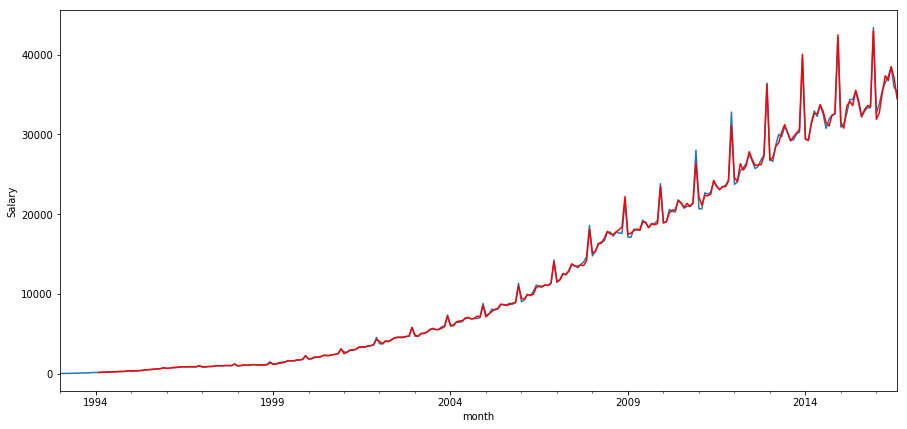

In [36]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

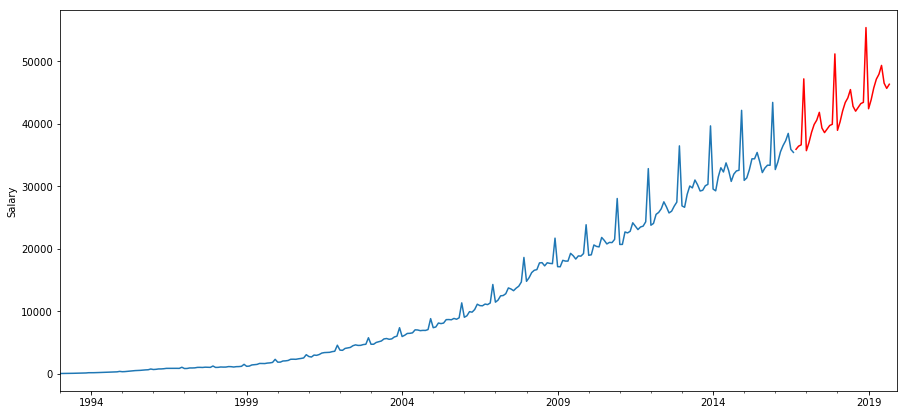

In [53]:
salary_forecast = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,40)]
future = pd.DataFrame(index=date_list, columns=salary_forecast.columns)
salary_forecast = pd.concat([salary_forecast, future])
salary_forecast['forecast'] = invboxcox(best_model.predict(start=284, end=284+36), lmbda)

plt.figure(figsize(15,7))
salary_forecast.WAG_C_M.plot()
salary_forecast.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

#### Визуально модель выглядит хорошей